In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [10]:
TRAIN_DIR = './data/train/'
TEST_DIR = './data/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR + filename for filename in os.listdir(TRAIN_DIR)]
train_dogs = [TRAIN_DIR + filename for filename in os.listdir(TRAIN_DIR) if 'dog' in filename]
train_cats = [TRAIN_DIR + filename for filename in os.listdir(TRAIN_DIR) if 'cat' in filename]

test_images = [TEST_DIR + filename for filename in os.listdir(TEST_DIR)]

train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
test_images = test_images[:25]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float32)
    
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(np.shape(train)))
print("Test shape: {}".format(test.shape))
import tensorflow as tf
train_init = tf.placeholder(tf.float32, shape=(2000, 64, 64, 3))
newTrain = tf.Variable(train_init)

sess = tf.Session()
sess.run(newTrain.assign(train_init), feed_dict={train_init: train})

Train shape: (2000, 64, 64, 3)
Test shape: (25, 64, 64, 3)


array([[[[ 71., 120., 193.],
         [ 71., 118., 190.],
         [ 74., 116., 189.],
         ...,
         [148., 202., 255.],
         [151., 202., 254.],
         [155., 204., 253.]],

        [[ 58., 107., 184.],
         [ 57., 110., 186.],
         [ 52., 109., 185.],
         ...,
         [126., 177., 242.],
         [132., 179., 243.],
         [144., 190., 249.]],

        [[ 97., 138., 200.],
         [ 94., 135., 197.],
         [ 83., 124., 186.],
         ...,
         [ 85., 118., 169.],
         [ 93., 125., 179.],
         [107., 138., 197.]],

        ...,

        [[162., 178., 191.],
         [156., 172., 185.],
         [154., 170., 183.],
         ...,
         [182., 193., 198.],
         [181., 191., 197.],
         [181., 193., 199.]],

        [[135., 154., 167.],
         [157., 173., 186.],
         [164., 175., 189.],
         ...,
         [152., 163., 186.],
         [131., 145., 161.],
         [115., 134., 140.]],

        [[157., 175., 188.],
       

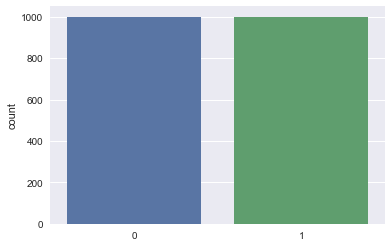

In [33]:
labels = [1 if "dog" in filename else 0 for filename in train_images]

sns.set()
sns.countplot(labels)


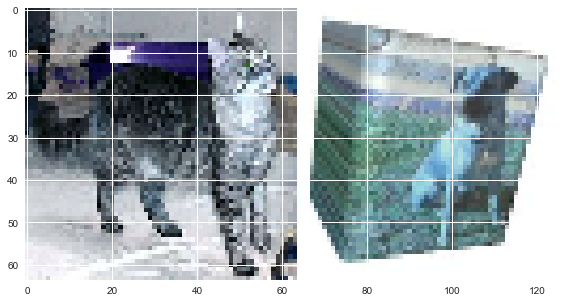

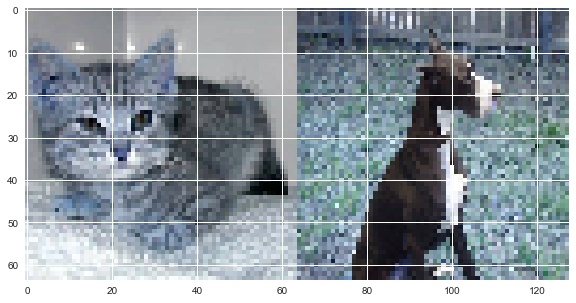

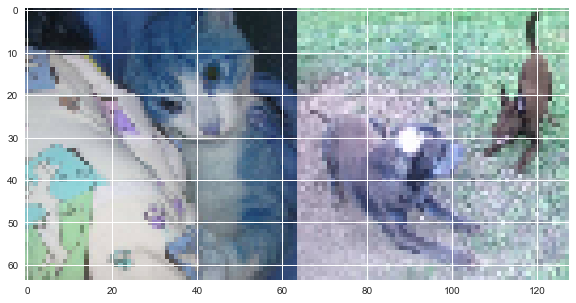

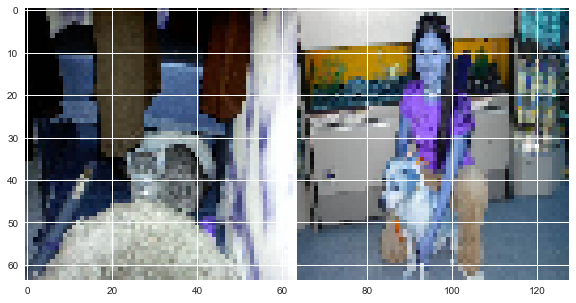

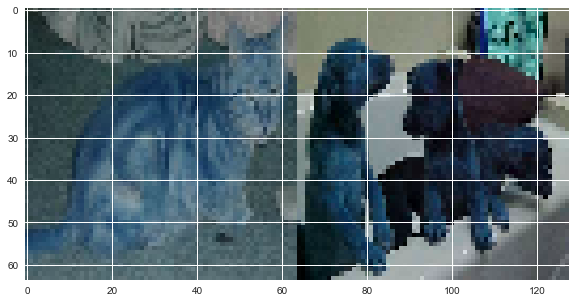

In [34]:
import matplotlib.pyplot as plt
# 检查下resize之后的图片样式
def show_cats_and_dogs(index):
    cat = read_image(train_cats[index])
    dog = read_image(train_dogs[index])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10, 5))
    plt.imshow(pair)
    plt.show()
    
# 展示五对图片的样式
for index in range(0, 5):
    show_cats_and_dogs(index)

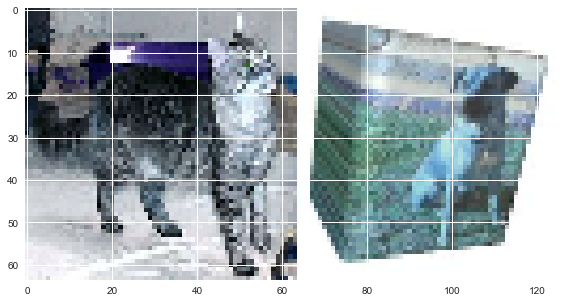

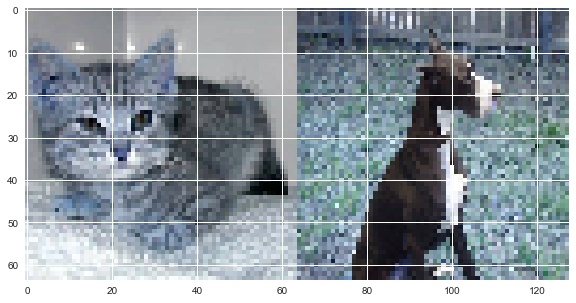

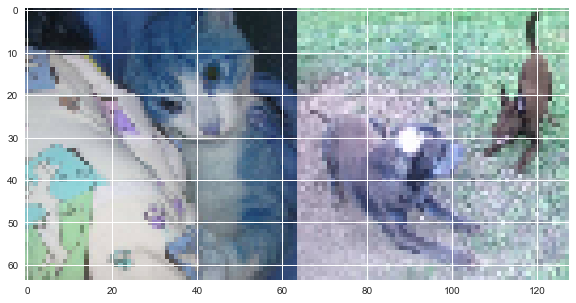

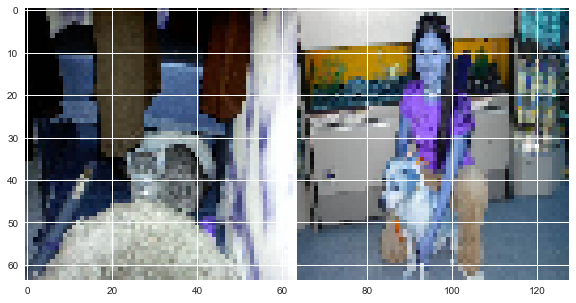

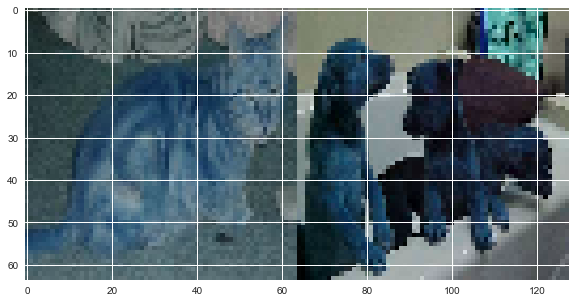

In [35]:
# 对数据集做归一化处理后的图片样式, 样式和未做归一化之前几乎一模一样
def show_cats_and_dogs(index):
    cat = read_image(train_cats[index])
    dog = read_image(train_dogs[index])
    pair = np.concatenate((cat, dog), axis=1) / 255
    plt.figure(figsize=(10, 5))
    plt.imshow(pair)
    plt.show()
    
# 展示五对图片的样式
for index in range(0, 5):
    show_cats_and_dogs(index)

In [36]:
# 对数据集做归一化
train = train / 255
test = test / 255
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (2000, 64, 64, 3)
Test shape: (25, 64, 64, 3)


In [37]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPool2D, Dense, Activation, Convolution2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [38]:
# 采用VGG-16网络中的部分结构
optimizer = RMSprop(lr=1e-4)
objective = "binary_crossentropy"

def catDogModel():
    model = Sequential()
    # 两层卷积层加一层池化层
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=(ROWS, COLS, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = catDogModel()

In [43]:
nb_epoch = 10
batch_size = 16


class LossHistory(Callback):
    """
    该类用来作为回调函数输出损失日志
    """
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
    
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))

early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode='auto')


def run_catdog():
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=nb_epoch, validation_split=0.25, verbose=0, 
             shuffle=True, callbacks=[history, early_stopping])
    
    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()
print(predictions)

[[0.5023835 ]
 [0.30500588]
 [0.6081722 ]
 [0.4912422 ]
 [0.5507049 ]
 [0.54817706]
 [0.60534304]
 [0.35310197]
 [0.55425364]
 [0.56397307]
 [0.5632221 ]
 [0.5301237 ]
 [0.516298  ]
 [0.57019836]
 [0.46824813]
 [0.48054132]
 [0.60104036]
 [0.4697597 ]
 [0.47009724]
 [0.5298933 ]
 [0.5410975 ]
 [0.5794349 ]
 [0.5634846 ]
 [0.5782492 ]
 [0.5785939 ]]


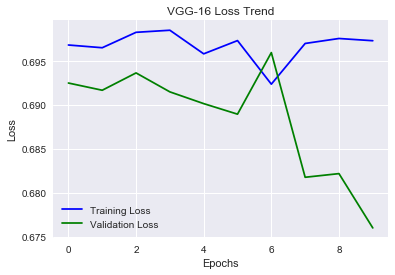

In [46]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, nb_epoch)[0::2])
plt.legend()
plt.show()